In [1]:
import yasp
# yasp.debug = True
import sys
import os
yasp_prefix = yasp.yasp_feature("prefix")
site_packages = os.path.join(sys.prefix, 'lib', f'python{sys.version[:3]}', 'site-packages')
add_path = os.path.join(yasp_prefix, 'lib', f'python{sys.version[:3]}', 'site-packages')
sys.path.append(add_path)

In [2]:
yasp.module_load_cppyy('bundle/hepbase')
yasp.module_load_cppyy('heppyy/current')
yasp.module_load_cppyy('alian/current')

import heppyy
fj = heppyy.load_cppyy('fastjet')
std = heppyy.load_cppyy('std')
alian_cpp = heppyy.load_cppyy('alian')

/Users/ploskon/devel/yasp/software/bundle/hepbase/root/default/lib/cppyy_backend/loader.py:90: UserWarning: No precompiled header available (/Users/ploskon/devel/yasp/software/bundle/hepbase/root/default/lib/cppyy_backend/etc not writable); this may impact performance.
  warnings.warn('No precompiled header available (%s); this may impact performance.' % msg)
[yasp-i] Running in Jupyter: True


In [3]:
import alian
if yasp.in_jupyter_notebook():
  from tqdm.notebook import tqdm
else:
  from tqdm import tqdm


In [11]:
fj.ClusterSequence().print_banner()

jet_algorithm = fj.antikt_algorithm
jet_R = 0.6
jet_eta_max = 2.0
bg_y_max = 0.9
bg_grid_spacing = 0.1

jet_def = fj.JetDefinition(jet_algorithm, jet_R)
area_def = fj.AreaDefinition(fj.active_area, fj.GhostedAreaSpec(jet_eta_max + jet_R, 1, 0.01))
jet_selector = fj.SelectorAbsEtaMax(jet_eta_max) * fj.SelectorPtMin(500.0)

# need for a background estimator?
bg_estimator = fj.GridMedianBackgroundEstimator(bg_y_max, bg_grid_spacing)

jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = fj.contrib.LundGenerator(jet_def_lund)
print('making lund diagram for all jets...')
print(f' {lund_gen.description()}')


making lund diagram for all jets...
 LundGenerator with Recluster with new_jet_def = Longitudinally invariant Cambridge/Aachen algorithm with R = 1 and E scheme recombination and keeping the hardest inclusive jet


In [12]:
pt_hat_min = 500

pythia_cmnd = os.path.join(alian.alian_settings.src_path, 'config/pythia-pp-hardQCD-5TeV-Monash.cmnd')
pythia_settings = ['PhaseSpace:pThatMin = {}'.format(pt_hat_min)]

from heppyy.pythia_util.configuration import create_and_init_pythia
pythia = create_and_init_pythia(pythia_settings, pythia_cmnd)


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version [i] strings read to PYTHIA  [['PhaseSpace:pThatMin = 500', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']]
[i] pythia initialized with ['PhaseSpace:pThatMin = 500', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on

In [13]:
from alian.io.pythia_io import psj_from_particle_with_index
pythia_offset_index = 0
nevents = 100
i = 0
for i in tqdm(range(nevents)):
    if not pythia.next():
        continue
    print(f'Event: {i} nparts: {pythia.event.size()}')
    i += 1
    psjv = std.vector[fj.PseudoJet]([psj_from_particle_with_index(p, i + pythia_offset_index) 
                                    for i, p in enumerate(pythia.event) if p.isFinal() and p.isVisible() and p.isCharged()])
    ca = fj.ClusterSequenceArea(psjv, jet_def, area_def)
    jets = fj.sorted_by_pt(jet_selector(ca.inclusive_jets()))
    leadpt = -1
    if jets.size() > 0:
        leadpt = jets[0].perp()
    else:
        continue
    print(f'{i} : n particles: {psjv.size()} -> njets: {jets.size()} | highest pt: {leadpt}')
    for j in jets:
        lunds = lund_gen.result(j)
        print(f'jet pT={j.perp()}')
        for i, l in enumerate(lunds):
            print('- L {} pT={:5.2f} eta={:5.2f}'.format(i, l.pair().perp(), l.pair().eta()))
            print('  Deltas={}'.format(l.Delta()))
            print('  kts={}'.format(l.kt()))
            print()


  0%|          | 0/100 [00:00<?, ?it/s]

Event: 0 nparts: 792
Event: 1 nparts: 574
Event: 2 nparts: 954
Event: 3 nparts: 599
Event: 4 nparts: 1166
Event: 5 nparts: 1404
Event: 6 nparts: 769
Event: 7 nparts: 1717
Event: 8 nparts: 785
9 : n particles: 126 -> njets: 1 | highest pt: 584.0298788308521
jet pT=584.0298788308521
- L 0 pT=584.03 eta= 0.01
  Deltas=0.5105503406269492
  kts=0.06728540442555947

- L 1 pT=583.90 eta= 0.01
  Deltas=0.4749698903428916
  kts=1.043412059467395

- L 2 pT=581.90 eta= 0.01
  Deltas=0.42448554154710466
  kts=4.799358573833959

- L 3 pT=571.46 eta= 0.02
  Deltas=0.35006430371312425
  kts=0.7467432567343764

- L 4 pT=569.34 eta= 0.01
  Deltas=0.10748788223323355
  kts=1.3491663233184292

- L 5 pT=556.86 eta= 0.01
  Deltas=0.06588434515826085
  kts=0.4287167787536832

- L 6 pT=550.35 eta= 0.01
  Deltas=0.022256621176584605
  kts=0.5774756680925354

- L 7 pT=524.40 eta= 0.02
  Deltas=0.019197202790051857
  kts=0.31925838788496774

- L 8 pT=507.77 eta= 0.01
  Deltas=0.008686897017303762
  kts=1.092897

In [14]:
pythia_offset_index = 0
nevents = 10000
i = 0
all_jets = []
for i in tqdm(range(nevents)):
    if not pythia.next():
        continue
    # print(f'Event: {i} nparts: {pythia.event.size()}')
    i += 1
    psjv = std.vector[fj.PseudoJet]([psj_from_particle_with_index(p, i + pythia_offset_index) 
                                    for i, p in enumerate(pythia.event) if p.isFinal() and p.isVisible() and p.isCharged()])
    ca = fj.ClusterSequenceArea(psjv, jet_def, area_def)
    jets = fj.sorted_by_pt(jet_selector(ca.inclusive_jets()))
    leadpt = -1
    if jets.size() > 0:
        leadpt = jets[0].perp()
    else:
        continue
    # print(f'{i} : n particles: {psjv.size()} -> njets: {jets.size()} | highest pt: {leadpt}')
    for j in jets:
        lunds = lund_gen.result(j)
        # print(f'jet pT={j.perp()}')
        j_dict = {'pt': j.perp(), 'eta': j.eta(), 'phi': j.phi(), 'area': j.area(), 'lunds': []}
        for i, l in enumerate(lunds):
            pt1 = l.harder().perp()
            pt2 = l.softer().perp()
            lund_dict = {'pt': l.pair().perp(), 'pt1': pt1, 'pt2': pt2, 'eta': l.pair().eta(), 'kt': l.kt(), 'delta': l.Delta()}
            j_dict['lunds'].append(lund_dict)
        all_jets.append(j_dict)
        
print(f'found {len(all_jets)} jets')
print(all_jets)

  0%|          | 0/10000 [00:00<?, ?it/s]

 PYTHIA Warning in StringFragmentation::fragmentToJunction: bad convergence junction rest frame
 PYTHIA Warning in SimpleSpaceShower::pT2nextQCD: weight above unity
found 1726 jets
[{'pt': 512.0980193193491, 'eta': -0.814859031920718, 'phi': 4.437281618358593, 'area': 1.1668772713333488, 'lunds': [{'pt': 512.098019319349, 'pt1': 510.9643036988827, 'pt2': 1.1552572105122116, 'eta': -0.814859031920718, 'kt': 0.47500744893658287, 'delta': 0.4111702957698716}, {'pt': 510.9643036988827, 'pt1': 510.6742294636754, 'pt2': 0.2973221173288908, 'eta': -0.8155375119133994, 'kt': 0.11732786584966823, 'delta': 0.3946153313575487}, {'pt': 510.6742294636754, 'pt1': 505.12846111803515, 'pt2': 5.782950643106092, 'eta': -0.8156777594208501, 'kt': 1.6774643699095595, 'delta': 0.29007067039544593}, {'pt': 505.12846111803515, 'pt1': 501.7867871687389, 'pt2': 3.3429047959960183, 'eta': -0.8154778535456157, 'kt': 0.18130910031429717, 'delta': 0.05423699189144157}, {'pt': 501.7867871687389, 'pt1': 423.31833668

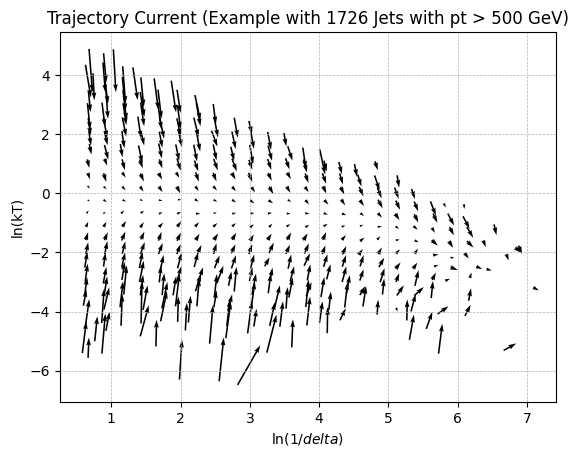

In [19]:
import pandas as pd
import numpy as np

records = []
for jet in all_jets:
    lunds = jet['lunds']
    for i in range(len(lunds) - 1):
        kt_i, delta_i = lunds[i]['kt'], lunds[i]['delta']
        kt_j, delta_j = lunds[i+1]['kt'], lunds[i+1]['delta']
        x_i, y_i = np.log(1/delta_i), np.log(kt_i)
        x_j, y_j = np.log(1/delta_j), np.log(kt_j)
        records.append({'x': x_i, 'y': y_i, 'dx': x_j - x_i, 'dy': y_j - y_i})

df = pd.DataFrame(records)

# Define grid and bin the (x,y) positions
nx, ny = 25, 25
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin
group = df.groupby(['ix', 'iy']).agg(
    x=('x', 'mean'),
    y=('y', 'mean'),
    dx=('dx', 'mean'),
    dy=('dy', 'mean')
).dropna().reset_index()

import matplotlib.pyplot as plt
# Plot the trajectory current
plt.figure()
plt.quiver(group['x'], group['y'], group['dx'], group['dy'])
plt.xlabel(r'ln(1/$delta$)')
plt.ylabel('ln(kT)')
plt.title(f'Trajectory Current (Example with {len(all_jets)} Jets with pt > {pt_hat_min} GeV)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()